In [264]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=365)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



In [265]:
import pandas as pd
import pymysql

class MySQLUpdater:
    def __init__(self, db_params, table_name, df_stocks, condition, method):
        self.db = pymysql.connect(**db_params)
        self.cursor = self.db.cursor()
        self.table_name = table_name
        self.df_stocks = df_stocks
        self.condition = condition
        self.method = method
        


    def update_records(self):
        # 遍历 DataFrame 中的每一行

        for i, row in self.df_stocks.iterrows():
            try:
                if(self.method == '1'):
                    # 构建 SQL 更新语句
                    sql = f"""
                    UPDATE `{self.table_name}`
                    SET `5MA` = %s,
                        `8MA` = %s,
                        `10MA` = %s,
                        `20MA` = %s,
                        `20RS` = %s,
                        `60MA` = %s,
                        `60RS` = %s
                    WHERE `{self.condition}` = %s AND `Date` = %s
                    """
                    # 执行更新语句
                    self.cursor.execute(sql, (float(row['5MA']),float(row['8MA']),float(row['10MA']),float(row['20MA']),float(row['20RS']),float(row['60MA']),float(row['60RS']), row[self.condition], row['Date']))

                    # 提交更改
                    self.db.commit()
                    
                elif (self.method == '2'):

                    # 构建 SQL 更新语句 更新標準化RS
                    sql = f"""
                    UPDATE `{self.table_name}`
                    SET `20RS_sd` = %s,
                        `20RS_rank` = %s
                    WHERE `{self.condition}` = %s AND `Date` = %s
                    """

                    # 执行更新语句
                    self.cursor.execute(sql, (float(row['20RS_sd']),float(row['20RS_rank']), row[self.condition], row['Date']))

                    # 提交更改
                    self.db.commit()

            except Exception as e:
                print(f"Error updating row {i}: {e}")
                self.db.rollback()

    def close_connection(self):
        self.cursor.close()
        self.db.close()

# 示例使用
db_params = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': '19970730',
    'database': 'sql_stock'
    # 設置MySQL資料庫連接
}

In [266]:
twse_df = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()

twse_df_na = twse_df.isna()
twse_df_update = twse_df[twse_df_na.any(axis=1)] #需要被更新的欄位

twse_df.loc[:, '5MA'] = twse_df['價格指數值'].rolling(5).mean()
twse_df.loc[:, '8MA'] = twse_df['價格指數值'].rolling(8).mean()
twse_df.loc[:, '10MA'] = twse_df['價格指數值'].rolling(10).mean()
twse_df.loc[:, '20MA']= twse_df['價格指數值'].rolling(20).mean()
twse_df.loc[:, '60MA']= twse_df['價格指數值'].rolling(60).mean()

twse_df.loc[:, '20RS'] = round((twse_df['價格指數值']/twse_df['20MA'])*100, 4)
twse_df.loc[:, '60RS'] = round((twse_df['價格指數值']/twse_df['60MA'])*100, 4)
twse_df = twse_df.fillna(0)
#twse_df_new = twse_df.iloc[-2:]
twse_df_new = twse_df.loc[twse_df_update.index]  # 只更新尚未計算的新欄位


# 初始化并更新数据库
updater = MySQLUpdater(db_params, 'daily_twse', twse_df_new, '指數名稱', '1')
updater.update_records()
updater.close_connection()

In [267]:
import numpy as np
stock_ids = stock_df_raw['證券代號'].unique().tolist()

stock_df_na = stock_df_raw.isna()
stock_df_update = stock_df_raw[stock_df_na.any(axis=1)] #需要被更新的欄位

for i in stock_ids:
        if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天
                #print(i)
                # 計算個股 RS
                temp_df = stock_df_raw[stock_df_raw['證券代號']==i].copy()

                temp_df.loc[:, '5MA'] = temp_df['收盤價'].rolling(5).mean()
                temp_df.loc[:, '8MA'] = temp_df['收盤價'].rolling(8).mean()
                temp_df.loc[:, '10MA'] = temp_df['收盤價'].rolling(10).mean()
                temp_df.loc[:, '20MA']= temp_df['收盤價'].rolling(20).mean()
                temp_df.loc[:, '60MA']= temp_df['收盤價'].rolling(60).mean()

                # 避免 temp_df['20MA']為0 
                if (temp_df['收盤價'] == 0).any() or (temp_df['20MA'] == 0).any():
                        temp_df.loc[:, '20RS'] = 0
                        temp_df.loc[:, '60RS'] = 0
                else :
                        temp_df.loc[:, '20RS'] = round((temp_df['收盤價']/temp_df['20MA'])*100, 4)
                        temp_df.loc[:, '60RS'] = round((temp_df['收盤價']/temp_df['60MA'])*100, 4)


                temp_df = temp_df.fillna(0)

                #只更新尚未update欄位
                temp_update_df = stock_df_update[stock_df_update['證券代號']==i].copy()
                temp_df_new = temp_df.loc[temp_update_df.index]  # 只更新尚未計算的新欄位
                # 初始化并更新数据库
                updater = MySQLUpdater(db_params, 'daily_price', temp_df_new, '證券代號','1')
                updater.update_records()
updater.close_connection()

In [331]:
# 

import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
start_date = pd.to_datetime(stock_df_update['Date']).unique().tolist()[0].date()
end_date = pd.to_datetime(stock_df_update['Date']).unique().tolist()[-1].date()

# 格式化日期
start_date = start_date.strftime('%Y%m%d')
end_date = end_date.strftime('%Y%m%d')

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{start_date}' AND date <= '{end_date}'
"""

stock_df_update_done = pd.read_sql(query_stock, engine)

In [269]:
# 計算個股對大盤RS
#先轉置取Date
stock_df_update_done['Date'] = pd.to_datetime(stock_df_update_done['Date'])

#stock_date_list = stock_df_raw['Date'].unique().tolist()
stock_date_list =  pd.to_datetime(stock_df_update['Date']).unique().tolist()  # 指查詢要更新的日期

#twse_df = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_df['Date'] = pd.to_datetime(twse_df_new['Date'])
twse_df.rename(columns={'20RS': '20RS_twse'}, inplace=True)
cols = ['Date', '價格指數值', '20RS_twse']
twse_df_forRS = twse_df[cols]

merged_df = pd.merge(stock_df_update_done, twse_df_forRS, on='Date', how='inner')
merged_df['20RS_sd'] = merged_df['20RS']/merged_df['20RS_twse']  #20MA計算RS
merged_df = merged_df.fillna(0)

col2 = ['Date', '證券代號', '20RS_sd','20RS_rank']
for i in range(len(stock_date_list)) :
    temp_merged_df = merged_df[merged_df['Date']==stock_date_list[i]].copy()
    # #標準化成0-100名
    temp_merged_df['20RS_rank'] = (temp_merged_df['20RS_sd'].rank(axis=0,method='first')/len(temp_merged_df))*100
    temp_merged_df = temp_merged_df[col2]


    # 初始化并更新数据库
    updater = MySQLUpdater(db_params, 'daily_price', temp_merged_df, '證券代號','2')
    updater.update_records()
updater.close_connection()



# df_rs_week = pd.concat([df_rs_week,df_rs70])
# df_rsall_week = pd.concat([df_rsall_week,df_rs])
# # 順便統計細產業佔比
# rs70_sub_category = get_sub_category_list(sub_category_list,df_rs70,day)                        
# df_rs70_category_week = pd.concat([df_rs70_category_week,rs70_sub_category])


C:\Users\USER\AppData\Local\Temp\ipykernel_15416\96721266.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


In [270]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=365)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')



# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
stock_df_raw = pd.read_sql(query_stock, engine)



In [271]:
import collections
df_rs70_category_week = pd.DataFrame()  #多筆每日強勢細產業

sub_category_list.rename(columns={'stock_id': '證券代號'}, inplace=True)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

for day in data_date_list:
        day = day.strftime('%Y-%m-%d')
        # 取每天RS大於90的產業出來
        stock_df_today = stock_df_raw[stock_df_raw['Date']==day].copy()  
        stock_df_today.sort_values(by=['20RS_rank'], inplace=True)

        stock_df_today90 = stock_df_today[stock_df_today['20RS_rank']>90]

        merged_rs_sub = pd.merge(stock_df_today90, sub_category_list, on='證券代號', how='inner')  #RS超過90的
        merged_sub = pd.merge(stock_df_today, sub_category_list, on='證券代號', how='inner')  # 全部股票

        cols = ['Date', '證券代號', 'stock_name','20RS_rank','main_category','sub_category']
        merged_rs_sub = merged_rs_sub[cols]
        merged_sub = merged_sub[cols]

        #找細產業別 跟 母體
        df_rs70_sub_category = collections.Counter(merged_rs_sub['sub_category'])
        df_all_sub_category = collections.Counter(merged_sub['sub_category'])

        df_sub_category = pd.DataFrame()
        for i in df_rs70_sub_category:
                sub_category = {
                "date": [day],
                "sub_category": [i],
                "main_rank": [df_rs70_sub_category[i]],
                "all": [df_all_sub_category[i]],
                "pen": [round((df_rs70_sub_category[i]/df_all_sub_category[i])*100,2)]}

                df_sub_category_temp = pd.DataFrame(sub_category)
                df_sub_category = pd.concat([df_sub_category,df_sub_category_temp])
                df_sub_category.sort_values(by=['pen'], ascending=False, inplace=True)

        df_rs70_category_week = pd.concat([df_rs70_category_week,df_sub_category])

                


In [317]:
compare_df = pd.DataFrame()
countdown = 60  #看輪動天數
pen = 40

for day in data_date_list:
        day_change = day.strftime('%Y-%m-%d')
        countdown -= 1 
        df_rs = pd.DataFrame()
        if(countdown>0):   
                getIndex = list(data_date_list).index(day) # 取index 找下一天
                day_before = list(data_date_list)[getIndex+1].strftime('%Y-%m-%d')
                df_rs70_category_1 = df_rs70_category_week[(df_rs70_category_week['date'] == day_change) &(df_rs70_category_week['main_rank'] > 2) & (df_rs70_category_week['pen'] > pen)]
                df_rs70_category_2 = df_rs70_category_week[(df_rs70_category_week['date'] == day_before) &(df_rs70_category_week['main_rank'] > 2) & (df_rs70_category_week['pen'] > pen)]

                sub_category_list_now = list(df_rs70_category_1['sub_category'])
                sub_category_before = list(df_rs70_category_2['sub_category'])
                compare_add = [x for x in sub_category_list_now if x not in sub_category_before] #新進入名單
                compare_remove = [x for x in sub_category_before if x not in sub_category_list_now] #新進入名單
                compare_list = {
                "Date": [day_change],
                "add": [compare_add],
                "remove": [compare_remove],
                "add_count": [len(compare_add)],
                "remove_count": [len(compare_remove)],
                "diff_count": [len(compare_add) - len(compare_remove)]}

                compare_list_temp = pd.DataFrame(compare_list)
                compare_df = pd.concat([compare_df,compare_list_temp])

In [315]:
compare_df30 = compare_df.iloc[:60]
compare_df30['Date'] = pd.to_datetime(compare_df30['Date'])
twse_index = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_index['Date'] = pd.to_datetime(twse_index['Date'])
merged_hist = pd.merge(compare_df30, twse_index, on='Date', how='inner')  # 全部股票

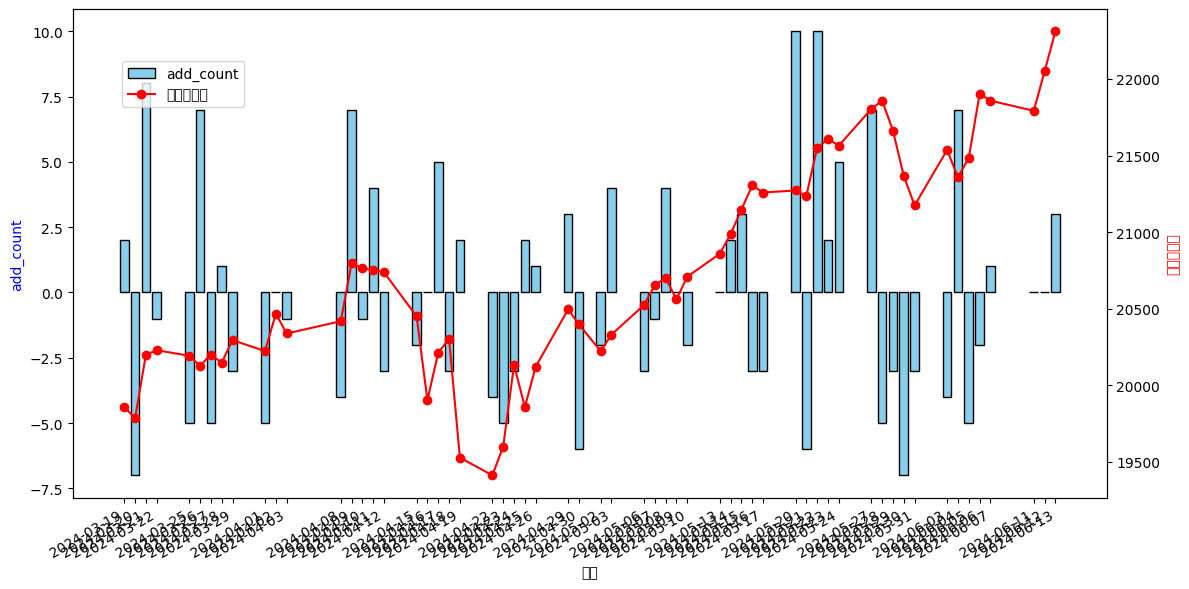

In [316]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# 禁用特定类型的警告
#warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
warnings.filterwarnings("ignore", category=UserWarning)

# 假设 compare_df30 和 merged_hist 的数据如下
compare_df30_data = {
    'date': merged_hist['Date'],
    'diff_count': merged_hist['diff_count']
}

merged_hist_data = {
    'date': merged_hist['Date'],
    '價格指數值': merged_hist['價格指數值']
}

compare_df30_df = pd.DataFrame(compare_df30_data)
merged_hist_df = pd.DataFrame(merged_hist_data)

# 确保日期列为 datetime 类型
compare_df30_df['date'] = pd.to_datetime(compare_df30_df['date'])
merged_hist_df['date'] = pd.to_datetime(merged_hist_df['date'])

# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制 compare_df30 的条形图
ax1.bar(compare_df30_df['date'], compare_df30_df['diff_count'], color='skyblue', edgecolor='black', label='add_count')

# 设置第一个 y 轴的标签
ax1.set_ylabel('add_count', color='blue')
ax1.set_xlabel('日期')



# 設置x軸刻度為實際存在的日期
ax1.set_xticks(compare_df30_df['date'])

# 格式化 x 轴为日期格式
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

# 自动旋转日期标签以避免重叠
fig.autofmt_xdate()

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制 merged_hist 的折线图
ax2.plot(merged_hist_df['date'], merged_hist_df['價格指數值'], color='red', marker='o', linestyle='-', label='價格指數值')
ax2.set_xticks(merged_hist_df['date'])

# 设置第二个 y 轴的标签
ax2.set_ylabel('價格指數值', color='red')

# 添加图例
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# 自动调整布局以适应标签
fig.tight_layout()

# 显示图表
plt.show()


In [333]:
#compare_df
# 看個別細產業
temp = sub_category_list[sub_category_list['sub_category'] == '記憶體']
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
temp2 = stock_df_raw[stock_df_raw['Date']=='2024-06-13']
temp3 = pd.merge(temp, temp2, on='證券代號', how='inner')  # 全部股票

cols = ['證券代號', 'stock_name', 'sub_category','20RS_rank','Date']
temp3 = temp3[cols]
temp3.sort_values(by=['20RS_rank'], inplace=True)
temp3



,證券代號,stock_name,sub_category,20RS_rank,Date
12,6276,安鈦克,記憶體,21.842818,2024-06-13
14,8084,巨虹,記憶體,24.390244,2024-06-13
16,8088,品安,記憶體,35.663957,2024-06-13
15,8088,品安,記憶體,35.663957,2024-06-13
0,2344,華邦電,記憶體,37.018970,2024-06-13
1,2344,華邦電,記憶體,37.018970,2024-06-13
13,6470,宇智,記憶體,44.878049,2024-06-13
11,5386,青雲,記憶體,46.883469,2024-06-13
18,8271,宇瞻,記憶體,70.460705,2024-06-13
5,3260,威剛,記憶體,72.845528,2024-06-13


In [342]:
tt = stock_df_raw[stock_df_raw['證券名稱'] == '信驊']
tt.tail(50)

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,漲跌價差,5MA,8MA,10MA,20MA,20RS,60MA,60RS,20RS_sd,20RS_rank
280158,2024-04-01,5274,信驊,535911,3034,1779172410,3350.0,3385.0,3245.0,3350.0,...,20.0,3230.0,3098.750,3048.0,2950.75,113.5305,2967.1667,112.9023,1.119135,97.874659
281993,2024-04-02,5274,信驊,371967,1600,1232931460,3340.0,3390.0,3270.0,3330.0,...,-20.0,3311.0,3160.625,3096.5,2970.75,112.0929,2970.0000,112.1212,1.094734,96.348774
283828,2024-04-03,5274,信驊,475119,1603,1622902195,3270.0,3480.0,3270.0,3405.0,...,75.0,3349.0,3221.875,3152.5,2993.75,113.7370,2975.2500,114.4442,1.120178,97.275204
285661,2024-04-08,5274,信驊,535244,1470,1810752725,3435.0,3485.0,3300.0,3405.0,...,0.0,3364.0,3286.250,3209.5,3016.00,112.8979,2980.0000,114.2617,1.109554,96.183206
287495,2024-04-09,5274,信驊,567161,3481,1823710260,3395.0,3410.0,3140.0,3225.0,...,-180.0,3343.0,3323.750,3240.5,3031.00,106.4005,2984.3333,108.0643,1.029252,88.549618
289329,2024-04-10,5274,信驊,384725,1009,1234965985,3160.0,3255.0,3160.0,3185.0,...,-40.0,3310.0,3320.000,3270.0,3044.25,104.6235,2988.8333,106.5633,1.016268,83.097056
291163,2024-04-11,5274,信驊,358266,1082,1130524785,3175.0,3225.0,3100.0,3170.0,...,-15.0,3278.0,3300.000,3294.5,3066.00,103.3920,2994.0000,105.8784,1.006894,79.880044
292997,2024-04-12,5274,信驊,161333,653,514703800,3165.0,3235.0,3165.0,3170.0,...,0.0,3231.0,3280.000,3290.0,3092.50,102.5061,2996.8333,105.7783,1.001066,75.081788
294831,2024-04-15,5274,信驊,258927,1047,807025020,3110.0,3180.0,3050.0,3115.0,...,-55.0,3173.0,3250.625,3268.5,3110.50,100.1447,2998.0833,103.8997,0.992974,62.540894
296665,2024-04-16,5274,信驊,190815,1155,579064775,3065.0,3065.0,3005.0,3015.0,...,-100.0,3131.0,3211.250,3237.0,3122.75,96.5495,2998.6667,100.5447,0.984209,53.871320


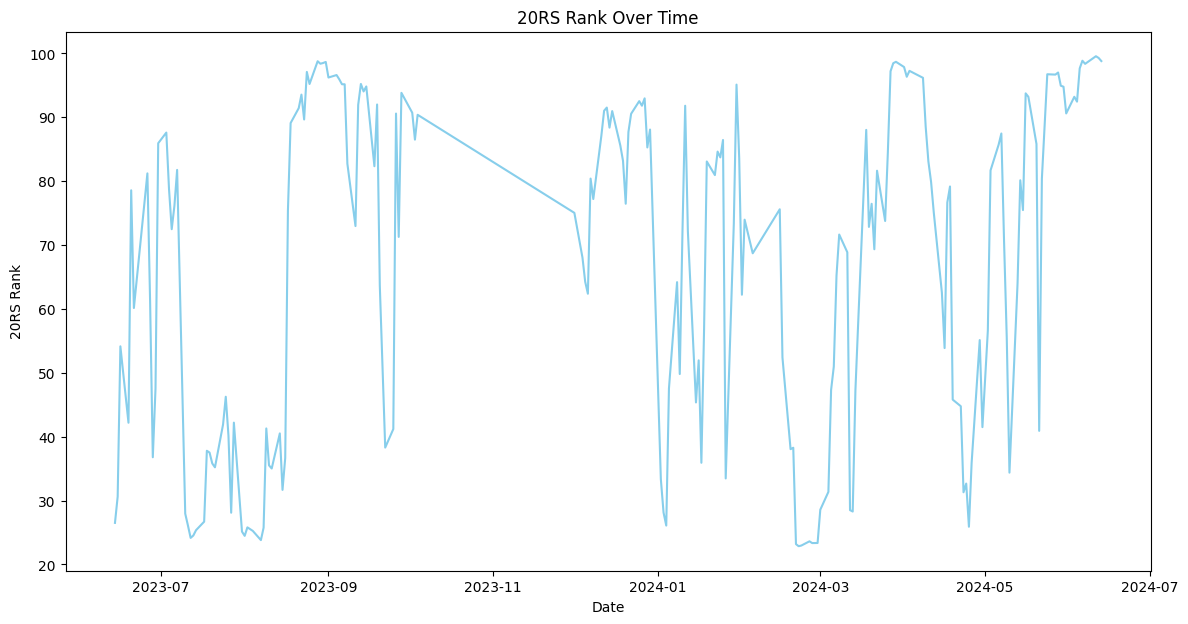

In [341]:
tt = stock_df_raw[stock_df_raw['證券名稱'] == '信驊']
import pandas as pd
import matplotlib.pyplot as plt


# 示例数据
data = {
    'date': tt['Date'],
    '20RS_rank': tt['20RS_rank']
}
tt_df = pd.DataFrame(data)

# 确保日期列是日期类型
tt_df['date'] = pd.to_datetime(tt_df['date'])

# 创建图表
plt.figure(figsize=(14, 7))
plt.plot(tt_df['date'], tt_df['20RS_rank'], color='skyblue')

# 设置标题和标签
plt.title('20RS Rank Over Time')
plt.xlabel('Date')
plt.ylabel('20RS Rank')

# 显示图表
plt.show()

# 可能需要60RS_RANK

In [322]:
# 用stock_df_raw for迴圈觀察大於1天
import collections
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

data_date = pd.to_datetime(stock_df_raw.index.get_level_values('date')).sort_values(ascending=False)
data_date_list = collections.Counter(data_date)


stock_df_today = stock_df_raw[stock_df_raw['Date']=='2024-05-28'].copy()  
stock_df_today.sort_values(by=['20RS_rank'], inplace=True)

stock_df_today90 = stock_df_today[stock_df_today['20RS_rank']>90]
stock_df_today90
#stock_df_today.tail(50)

KeyError: 'Requested level (date) does not match index name (None)'

In [71]:
sub_category_list.rename(columns={'stock_id': '證券代號'}, inplace=True)
merged_rs_sub = pd.merge(stock_df_today90, sub_category_list, on='證券代號', how='inner')  #RS超過90的
merged_sub = pd.merge(stock_df_today, sub_category_list, on='證券代號', how='inner')  # 全部股票

cols = ['Date', '證券代號', 'stock_name','20RS_rank','main_category','sub_category']
merged_rs_sub = merged_rs_sub[cols]
merged_sub = merged_sub[cols]

import collections
df_rs70_sub_category = collections.Counter(merged_rs_sub['sub_category'])

sub_category_list = collections.Counter(merged_sub['sub_category'])



In [72]:

df_sub_category = pd.DataFrame()
for i in df_rs70_sub_category:
    sub_category = {
    "date": ['2024-05-28'],
    "sub_category": [i],
    "main_rank": [df_rs70_sub_category[i]],
    "all": [sub_category_list[i]],
    "pen": [round((df_rs70_sub_category[i]/sub_category_list[i])*100,2)]}

    df_sub_category_temp = pd.DataFrame(sub_category)
    df_sub_category = pd.concat([df_sub_category,df_sub_category_temp])
df_sub_category.sort_values(by=['pen'], ascending=False, inplace=True)

In [73]:
df_rs70_category_week = pd.DataFrame()

df_rs70_category_week = pd.concat([df_rs70_category_week,rs70_sub_category])

,date,sub_category,main_rank,all,pen
0,2024-05-28,通訊,1,1,100.00
0,2024-05-28,資安審計,1,1,100.00
0,2024-05-28,微型顯示器/光機引擎(Light Engine),1,1,100.00
0,2024-05-28,Micro LED,1,1,100.00
0,2024-05-28,OLED,1,1,100.00
...,...,...,...,...,...
0,2024-05-28,保健食品代理銷售及通路,1,30,3.33
0,2024-05-28,貿易商、代理商、經銷商,1,30,3.33
0,2024-05-28,金控業/銀行業/保險業,1,33,3.03
0,2024-05-28,零售通路,1,37,2.70


In [302]:
# 取得細產業資料
def get_sub_category_list(df_sub_category_list, df_rs70, date):
    import collections
    sub_industry_list=[]
    for i in df_rs70.index:
        try:
            temp = df_sub_category_list.loc[i].sub_category

            if(isinstance(temp, str)):
                sub_industry_list.append(temp)
            else:
                for j in temp:
                    sub_industry_list.append(j)                    
        except:
            pass
            #print(df_rs70.loc[i]['stock_name'])

    df_rs70_sub_category = collections.Counter(sub_industry_list)
    sub_category_list = collections.Counter(df_sub_category_list['sub_category'])

    df_sub_category = pd.DataFrame()
    for i in df_rs70_sub_category:
        sub_category = {
        "date": [date],
        "sub_category": [i],
        "main_rank": [df_rs70_sub_category[i]],
        "all": [sub_category_list[i]],
        "pen": [round((df_rs70_sub_category[i]/sub_category_list[i])*100,2)]}

        df_sub_category_temp = pd.DataFrame(sub_category)
        df_sub_category = pd.concat([df_sub_category,df_sub_category_temp])
    df_sub_category.sort_values(by=['pen'], ascending=False, inplace=True)

    return df_sub_category
